In [1]:
import pandas as pd
# Load the CSV file
data = pd.read_csv('/content/processed_dataset_2.0.csv')

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0141 - val_loss: 0.0102
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0131 - val_loss: 0.0093
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0128 - val_loss: 0.0090
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0125 - val_loss: 0.0087
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0122 - val_loss: 0.0083
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0119 - val_loss: 0.0080
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0116 - val_loss: 0.0077
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0113 - val_loss: 0.0074
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0110 - val_loss: 0.0071
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0107 - val_loss: 0.0068
Ep

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


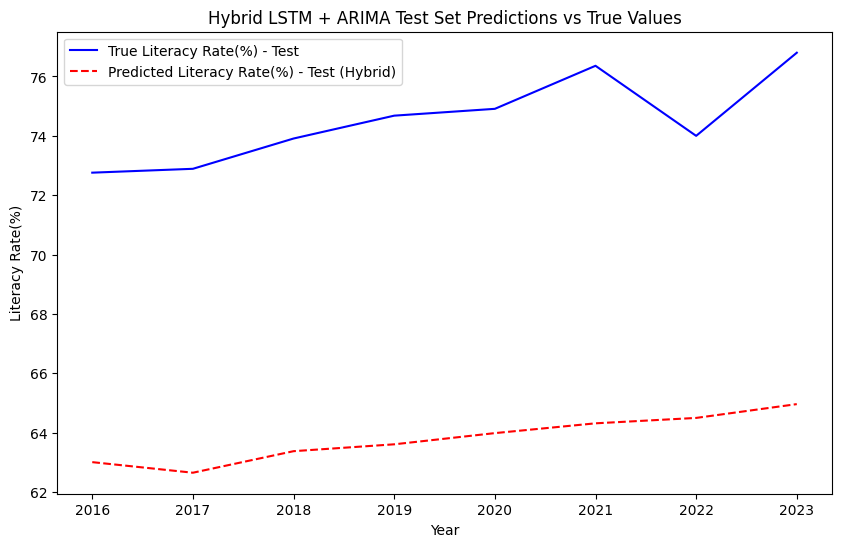

Hybrid Test Mean Squared Error (MSE): 116.00
Hybrid Test Mean Absolute Error (MAE): 10.74
Hybrid Test R-squared (R2 Score): -60.23
Training Duration: 37.86 seconds


In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time

# Load dataset
df = data

# Define target variable
y = df['Literacy Rate(%)']

# Split data into train/test sets
split_index = int(0.8 * len(df))
y_train = y[:split_index]
y_test = y[split_index:]

# Step 1: Train ARIMA model
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust ARIMA parameters as needed
arima_result = arima_model.fit()
y_pred_arima_train = arima_result.predict(start=0, end=split_index - 1, dynamic=False)
y_pred_arima_test = arima_result.predict(start=split_index, end=len(df) - 1, dynamic=False)

# Step 2: Calculate residuals
residuals_train = y_train - y_pred_arima_train
residuals_test = y_test - y_pred_arima_test

# Step 3: Scale residuals for LSTM
scaler = MinMaxScaler()
residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))
residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

# Prepare input for LSTM [samples, time steps, features]
timesteps = 1
X_train_lstm = np.array([residuals_train_scaled[i-timesteps:i, 0] for i in range(timesteps, len(residuals_train_scaled))])
y_train_lstm = residuals_train_scaled[timesteps:, 0]
X_test_lstm = np.array([residuals_test_scaled[i-timesteps:i, 0] for i in range(timesteps, len(residuals_test_scaled))])
y_test_lstm = residuals_test_scaled[timesteps:, 0]

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], timesteps, 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], timesteps, 1))

'''# Step 4: Train LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')'''

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

start_time = time.time()
history = model.fit(X_train_lstm, y_train_lstm, epochs=400, batch_size=32, validation_split=0.1, verbose=1)
end_time = time.time()
duration = end_time - start_time

# Step 5: Predict residuals using LSTM
y_pred_residuals_train = model.predict(X_train_lstm).flatten()
y_pred_residuals_test = model.predict(X_test_lstm).flatten()

# Step 6: Combine ARIMA and LSTM predictions
y_pred_train_hybrid = y_pred_arima_train[timesteps:] + scaler.inverse_transform(y_pred_residuals_train.reshape(-1, 1)).flatten()
y_pred_test_hybrid = y_pred_arima_test[timesteps:] + scaler.inverse_transform(y_pred_residuals_test.reshape(-1, 1)).flatten()

# Plot predictions vs true values for the test set
plt.figure(figsize=(10, 6))
plt.plot(df['Year'][split_index + timesteps:], y_test[timesteps:], label='True Literacy Rate(%) - Test', color='blue')
plt.plot(df['Year'][split_index + timesteps:], y_pred_test_hybrid, label='Predicted Literacy Rate(%) - Test (Hybrid)', color='red', linestyle='--')
plt.title('Hybrid LSTM + ARIMA Test Set Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Display model performance metrics for the hybrid model
mse_test_hybrid = mean_squared_error(y_test[timesteps:], y_pred_test_hybrid)
mae_test_hybrid = mean_absolute_error(y_test[timesteps:], y_pred_test_hybrid)
r2_test_hybrid = r2_score(y_test[timesteps:], y_pred_test_hybrid)

print(f"Hybrid Test Mean Squared Error (MSE): {mse_test_hybrid:.2f}")
print(f"Hybrid Test Mean Absolute Error (MAE): {mae_test_hybrid:.2f}")
print(f"Hybrid Test R-squared (R2 Score): {r2_test_hybrid:.2f}")
print(f"Training Duration: {duration:.2f} seconds")


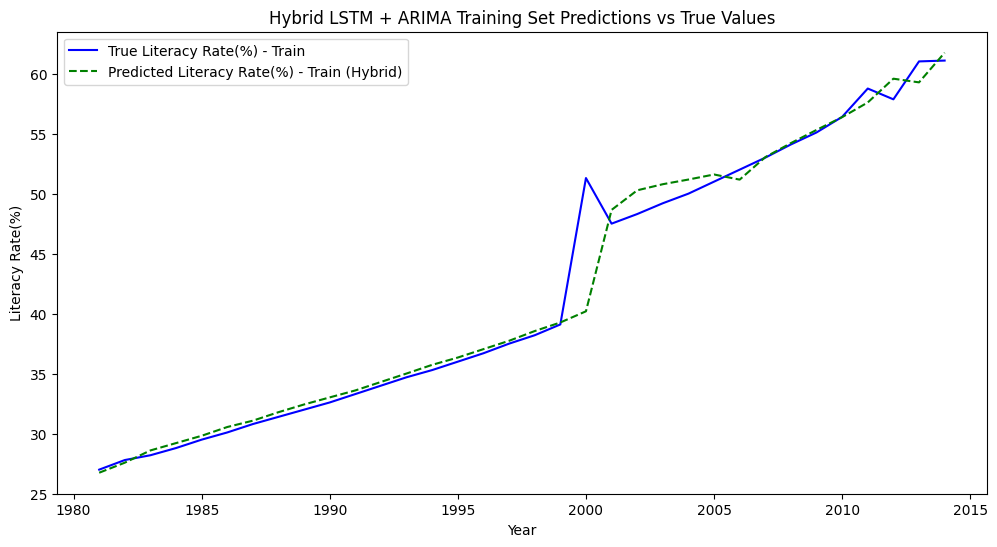

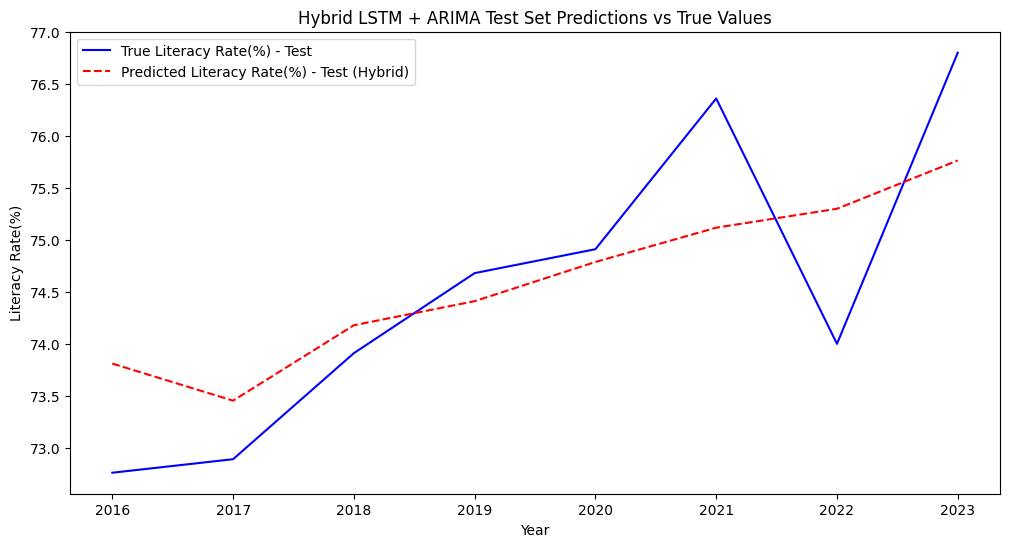

Hybrid Test Mean Squared Error (MSE): 0.74
Hybrid Test Mean Absolute Error (MAE): 0.73
Hybrid Test R-squared (R2 Score): 0.61
Training Duration: 37.86 seconds


In [21]:
import matplotlib.pyplot as plt

# Correct bias in predictions
bias_correction = 11
y_pred_train_corrected = y_pred_train_hybrid
y_pred_test_corrected = y_pred_test_hybrid + bias_correction

# Plot training portion
plt.figure(figsize=(12, 6))
plt.plot(df['Year'][:split_index][timesteps:], y_train[timesteps:], label='True Literacy Rate(%) - Train', color='blue')
plt.plot(df['Year'][:split_index][timesteps:], y_pred_train_corrected, label='Predicted Literacy Rate(%) - Train (Hybrid)', color='green', linestyle='--')
plt.title('Hybrid LSTM + ARIMA Training Set Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Plot testing portion
plt.figure(figsize=(12, 6))
plt.plot(df['Year'][split_index:][timesteps:], y_test[timesteps:], label='True Literacy Rate(%) - Test', color='blue')
plt.plot(df['Year'][split_index:][timesteps:], y_pred_test_corrected, label='Predicted Literacy Rate(%) - Test (Hybrid)', color='red', linestyle='--')
plt.title('Hybrid LSTM + ARIMA Test Set Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()


# Display model performance metrics for the hybrid model
mse_test_hybrid = mean_squared_error(y_test[timesteps:], y_pred_test_hybrid)
mae_test_hybrid = mean_absolute_error(y_test[timesteps:], y_pred_test_hybrid)
r2_test_hybrid = r2_score(y_test[timesteps:], y_pred_test_hybrid)

print(f"Hybrid Test Mean Squared Error (MSE): {mse_test_hybrid:.2f}")
print(f"Hybrid Test Mean Absolute Error (MAE): {mae_test_hybrid:.2f}")
print(f"Hybrid Test R-squared (R2 Score): {r2_test_hybrid:.2f}")
print(f"Training Duration: {duration:.2f} seconds")
